In [11]:
import os
import time
import torch
from PIL import Image
import torchvision
import numpy as np
from tqdm import tqdm
from torch import optim
from scipy.ndimage import zoom
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import random
import pandas as pd
from utils import * 
from model import SAM_CFFNet

In [2]:
def parse_args():
    import argparse
    parser = argparse.ArgumentParser(description="pytorch SAM_CFFNet training")
    parser.add_argument("--local_rank"     , default = 0, type=int,  help="")
    parser.add_argument("--dataset"        , choices = ["BJL", "L4S", "GVLM"], default="GVLM")
    parser.add_argument("--sam_pretrained_weights", default = None, type=str, help="path to SAM model pretrained weights file")
    parser.add_argument("--encoder_mode"   , default= "l")
    parser.add_argument('--modelname'      , default = 'SAM_CFFNet', type=str, metavar='data', help='model name')
    parser.add_argument("--batch_size"     , default = 2, type=int,  help="")
    parser.add_argument("--num_classes"    , default = 1 + 1, type=int, help="加上背景")
    parser.add_argument('--epochs'         , default = 30, type=int, metavar='N', help='total epochs')
    parser.add_argument('--lr'             , default = 0.0002, type=float, help='initial learning rate')
    parser.add_argument('--lr_min'         , default = 1e-07, type=float)
    parser.add_argument('--inp_size'       , default = 1024, type=float)
    parser.add_argument('--resume'         , default = '/home/mw/work/sam_cffnet', type=str, metavar='PATH')
    parser.add_argument("--device"         , default = 'cpu', type=str,  help="")
    parser.add_argument('--momentum', default=0.9, type=float, metavar='M',help='momentum')

    # args = parser.parse_args()

    args = parser.parse_known_args()[0]

    return args

In [3]:
seed_everything(100)
args = parse_args()

args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
sam_cffnet = SAM_CFFNet(args)
model = sam_cffnet.cuda()

In [5]:
model_weight_path = r"./sam_cffnet_weight/gvlm_best.pth.tar"
weight_dict = torch.load(model_weight_path, map_location='cuda')['state_dict']
model.load_state_dict(weight_dict)

<All keys matched successfully>

In [6]:
class jpeg_png_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):

        self.images_dir = data_dir + os.sep + 'images'
        self.labels_dir = data_dir + os.sep + 'labels'
        img_list    = sorted(os.listdir(self.images_dir))
        images = [i for i in img_list if i.endswith('.jpeg')]
        random.shuffle(images)
        self.images = images

        
        self.inp_size=1024

        self.img_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((self.inp_size, self.inp_size)),
        torchvision.transforms.ToTensor()
    ])

        self.mask_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((self.inp_size, self.inp_size)),
        torchvision.transforms.Grayscale(),  # 将图像转换为灰度模式
        torchvision.transforms.Lambda(lambda x: x.point(lambda p: p > 128 and 255)),  # 进行二值化操作
        torchvision.transforms.ToTensor(),
    ])
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        PILimg = Image.open(self.images_dir + os.sep + self.images[i])
        label_arry = Image.open(self.labels_dir + os.sep + self.images[i][:-5] + '.png')

        return self.img_transform(PILimg),  self.mask_transform(label_arry)#PILlabel)


In [7]:
show_data = jpeg_png_Dataset('./datas')
data_loader = torch.utils.data.DataLoader(show_data, batch_size=2, shuffle=False,drop_last=True)

In [22]:
evaluator = Evaluator(2)

test_reselt  = validationing(data_loader,   model,  0, evaluator, args)
df = pd.DataFrame.from_dict(test_reselt, orient='index', columns=['Value'])
df = df.loc[['presion', 'recall', 'F1score', 'mIou', 'Iou 1']]
df

,Value
presion,0.919358
recall,0.899844
F1score,0.909169
mIou,0.838464
Iou 1,0.742588


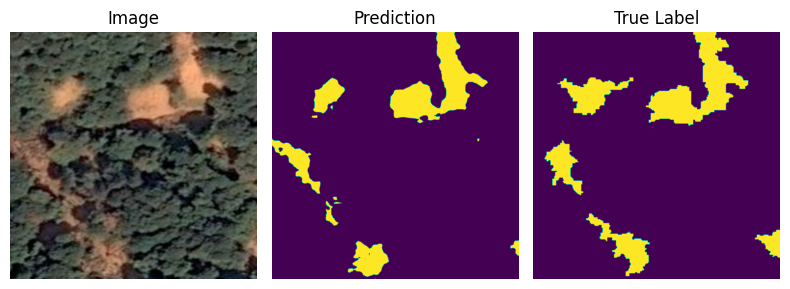

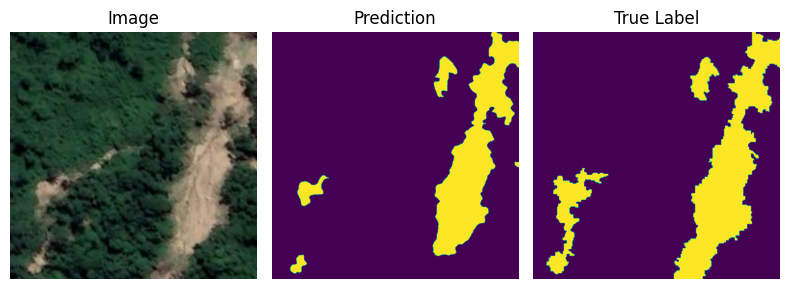

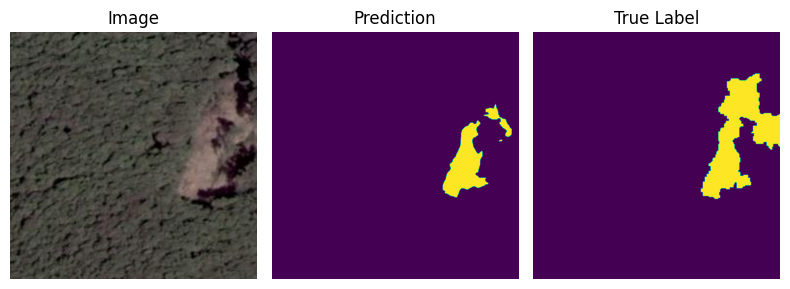

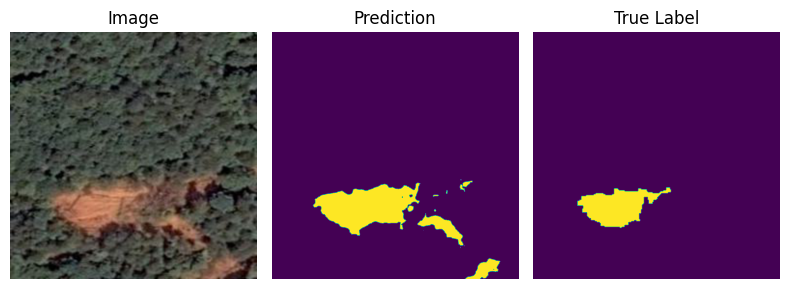

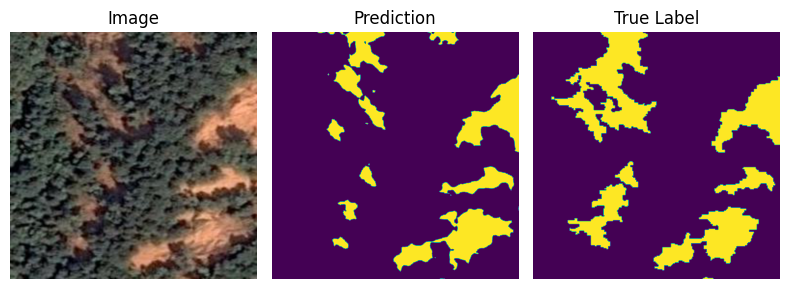

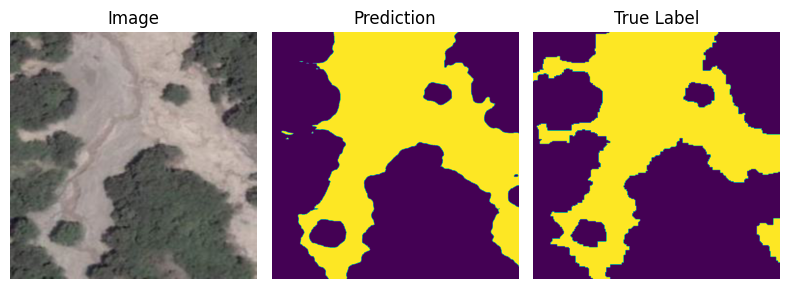

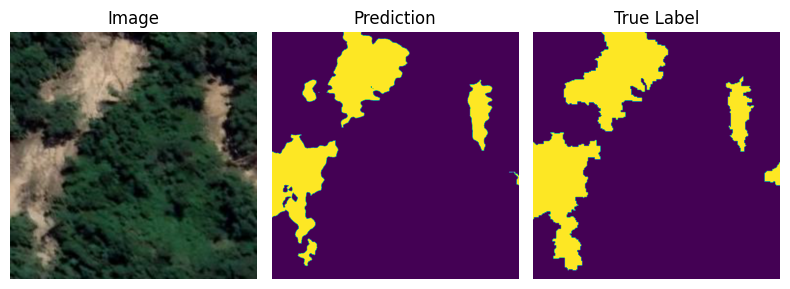

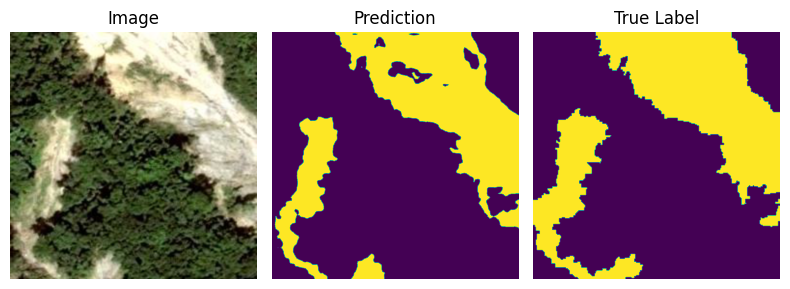

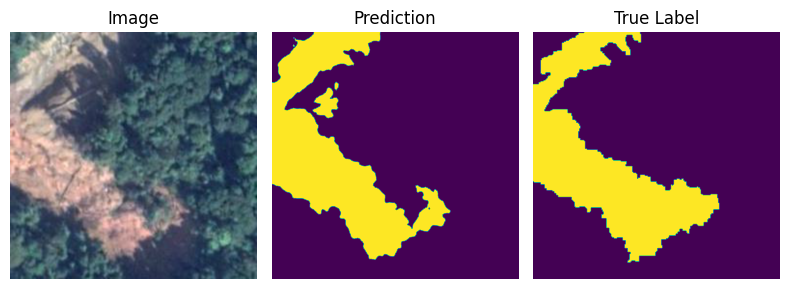

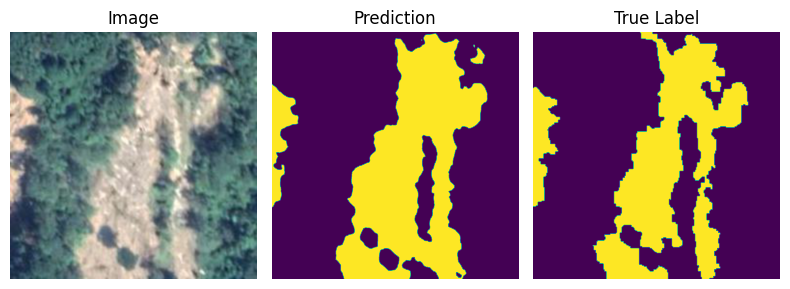

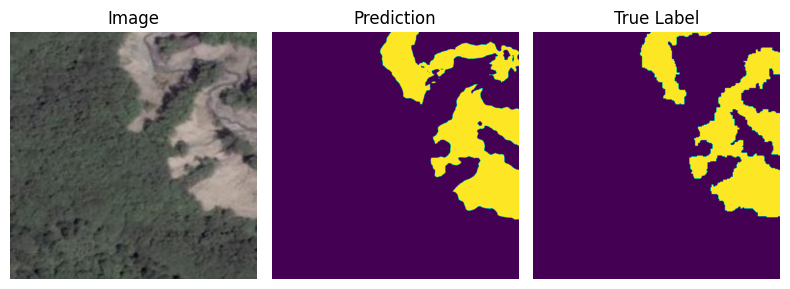

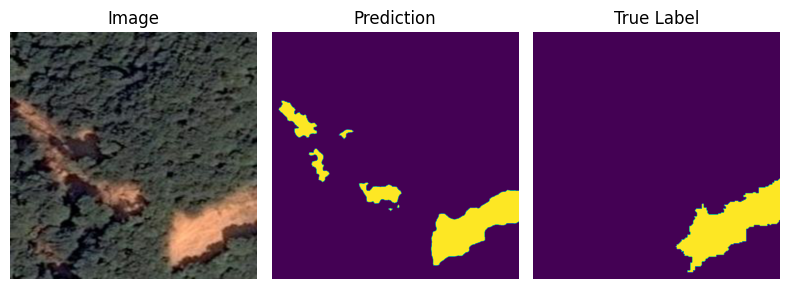

In [9]:
model.eval()

for i, (x, y) in enumerate(data_loader):
    rgb = x.to(args.device)
    with torch.no_grad():
        output = model(rgb.float())
    output[output > 0.5] = 1
    output[output <= 0.5] = 0
    predictions = output.cpu().detach().numpy()
    # 可视化预测结果和真实标签
    for ii in range(2):
        display_images_with_predictions_and_labels(
            x[ii].detach().numpy(), predictions[ii], y[ii].detach().numpy()
        )
